# Inference
The topic of this notebook is to prototype the creation of an inference pipeline that will serve as a guideline for the actual system to be implemented.

## Plan
1. Go through a single scene of the FDST images. [done]
2. Define and extract zones of interest. [done]
3. Warp the perspective of a single image to 4 different images (3 warped, 1 original). [done]
4. Use the model to get the count of people in each segment of the image, as well as each perspective. [in progress]
5. Average the number of the predicted count for each zone of interest. [todo]

## Motivation
Since in the original idea 4 cameras are going to be used to count the people in one hall the goal is to simulate that by wapring the perspective of each image. Before hand some zones of interest need to be defined (3 to begin with). Then for each defined zone average the infered count.

## Imports and Globals

In [1]:
import os
import sys
import cv2
import glob
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [2]:
from models.definitions.csr import CSRNet
from models.definitions.dsnet import DenseScaleNet

In [3]:
BEST_MODEL_SAVE_PATH = 'models/best/'
CKP_MODEL_SAVE_PATH = 'models/checkpoints/'
FDST_TEST_IMAGES = 'training_dataset/fdst/test_data/90/'
MODEL_INPUT_SIZE = (720, 480)
EXAMPLE_IMAGE_JPG = os.path.join(FDST_TEST_IMAGES, '001.jpg')
EXAMPLE_IMAGE_JSON = os.path.join(FDST_TEST_IMAGES, '001.json')
DSNET_WEIGHTS_FILEPATH = os.path.join(BEST_MODEL_SAVE_PATH, 'DenseScaleNet_aug_e162_1e-05.pth')
CSRNET_WEIGHTS_FILEPATH = os.path.join(BEST_MODEL_SAVE_PATH, 'CSRNet_aug_e211.pth')

### Utilities
Some functions that provide various utilities and helper functions.

#### 1. Model Related

In [4]:
def load_pretrained_model(model_filepath):
    '''
        Load the model from the filepath
    '''
    state = torch.load(checkpoint_filepath)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    epoch = state['epoch']
    return epoch, model, optimizer

#### 2. Image transformation and augmentation.

In [5]:
def show_image(img, plot_area=(15, 10)):
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.imshow(img)   

def show_image_from_path(path, plot_area=(15, 10)):
    image = cv2.imread(path)
    show_image(image, plot_area)

In [6]:
def fill_zone(img, points, color):
    points = np.array(points)
    return cv2.fillPoly(img, pts=[points], color=color)

In [7]:
def blend_images(raw_img, updated_img, opacity):
    return cv2.addWeighted(raw_img, 1-opacity, updated_img, opacity, 0)

In [8]:
def extract_zone_image(img, zone):
    stencil = np.zeros(img.shape).astype(img.dtype)
    stencil = fill_zone(stencil, [zone], [255, 255, 255])
    return cv2.bitwise_and(img, stencil)

def extract_images_from_zones(zones_obj, source_image):
    segment_image_obj = {}
    for zone in zones_obj.keys():
        segment_image_obj[zone] = extract_zone_image(source_image, zones_obj[zone])
    
    return segment_image_obj

#### 3. Zone-of-Interest Extractor

In [9]:
def parse_zone(zone):
    # example_zone = [low_left, low_right, up_right, up_left]
    low_left, low_right, up_right, up_left = 0, 0, 0, 0
    sorted_zone = sorted(zone)
    
    lefts = sorted_zone[:2]
    rights = sorted_zone[2:]

    sorted_lefts = sorted(lefts, key=lambda x: x[1], reverse=True)
    sorted_rights = sorted(rights, key=lambda x: x[1], reverse=True)

    low_left, up_left = sorted_lefts[0], sorted_lefts[1]
    low_right, up_right = sorted_rights[0], sorted_rights[1]
    
    return [low_left, low_right, up_right, up_left]
    
def read_and_parse_zone_json(json_filepath):
    obj = json.load(open(json_filepath))
    parsed_zones = {}
    
    for zone in obj.keys():
        parsed_zones[zone] = parse_zone(obj[zone])
    
    return parsed_zones

#### 4. Image perspective mutation

In [10]:
def gen_sign():
    # make sure its not a zero
    ret_int = random.randint(-1, 1)
    
    while ret_int == 0:
        ret_int = random.randint(-1, 1)
        
    return ret_int

def resize(img, target_shape):
    return cv2.resize(img, target_shape, interpolation=cv2.INTER_CUBIC)
    
def transform_goal_coordinates(origin_points, drift):
    new_points = []
    
    for point in origin_points:
        transform_x = gen_sign() * drift
        transform_y = gen_sign() * drift
        
        new_points.append([point[0] + transform_x, point[1] + transform_y])
        
    return new_points
    
def afflineTransform(img, anchor, drift):
    rows, cols, ch = img.shape
    
    pts1 = np.float32(anchor)
    # generate the second set of points
    pts2 = np.float32(transform_goal_coordinates(anchor, drift))
    
    M = cv2.getAffineTransform(pts1,pts2)

    return cv2.warpAffine(img,M,(cols,rows))    

In [11]:
def apply_transforms(segmented_imgs, n_transforms, anchor, drift, resize_to_target=False):
    result_imgs = []
    for i in range(n_transforms):
        segmented_imgs_tmp = {}
        for zone in segmented_imgs.keys():
            transformed_img = afflineTransform(segmented_imgs[zone], anchor, drift)
            if resize_to_target:
                transformed_img = resize(transformed_img, MODEL_INPUT_SIZE)
            segmented_imgs_tmp[zone] = transformed_img
        result_imgs.append(segmented_imgs_tmp)
    
    # don't forget to resize the segmented imgs as well
    if resize_to_target:
        for zone in segmented_imgs.keys():
            resized_img = resize(segmented_imgs[zone], MODEL_INPUT_SIZE)
            segmented_imgs[zone] = resized_img
            
    result_imgs.append(segmented_imgs)
    return result_imgs

## Plan Execution

### 1. Go through a single scene from FDST
What 'going-through' means a single image from the FDST dataset will be explored and analyzed for the purpose of the inference.

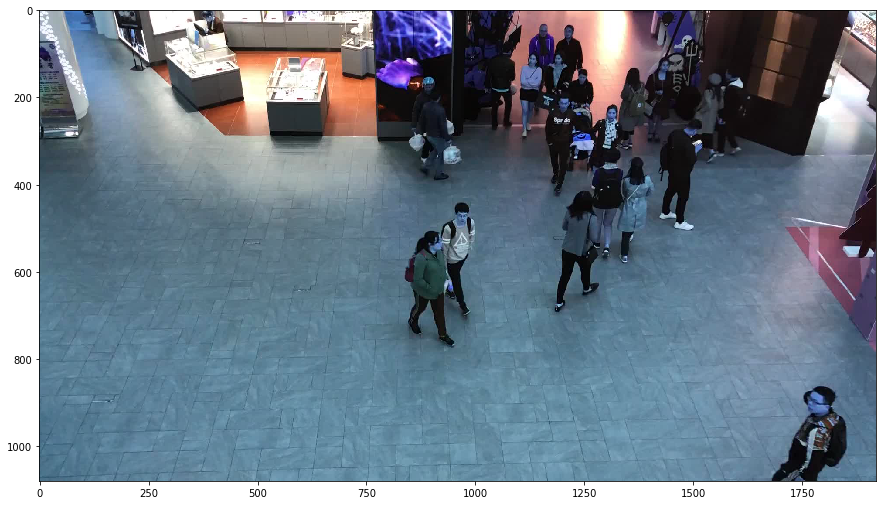

In [12]:
show_image_from_path(EXAMPLE_IMAGE_JPG)

As the example shows the image is suitable for analysis and perspective distortion as this is the sort of images we expect from the real scenario.

### 2. Define and extract the zones of interest
As stated above the goal is to have 3 zones of interest defined, on which to have perform inference.

In [13]:
# example_zone = [low_left, low_right, up_right, up_left]
zone_one = [(1050, 750), (1850, 750), (1650, 30), (1000, 25)]
zone_two = [(100, 750), (1010, 750), (980, 45), (120, 40)]
zone_three = [(100, 1050), (1850, 1050), (1850, 810), (80, 810)]
zones = [zone_one, zone_two, zone_three]

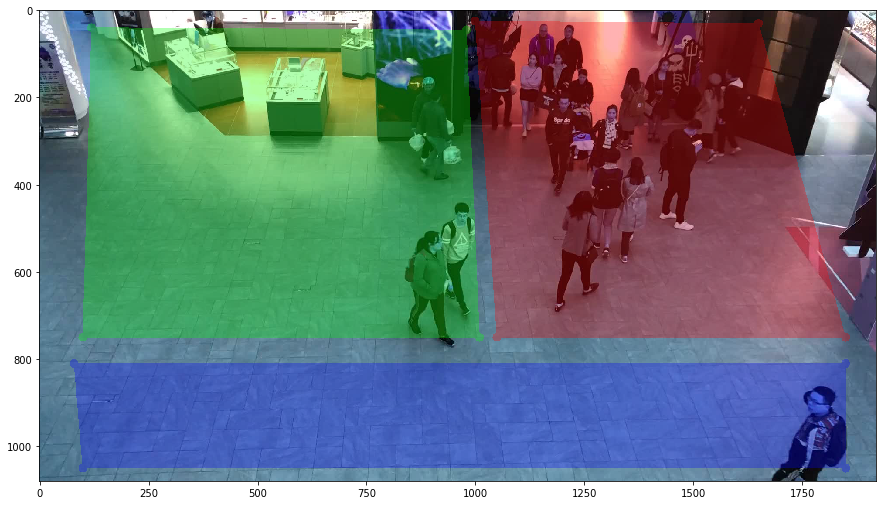

In [14]:
img = cv2.imread(EXAMPLE_IMAGE_JPG)

for point in zone_one:
    cv2.circle(img, point, 10, (255, 0, 0), -1)

for point in zone_two:
    cv2.circle(img, point, 10, (0, 255, 0), -1)

for point in zone_three:
    cv2.circle(img, point, 10, (0, 0, 255), -1)

# add colors to the zones
active = 0
for zone in zones:
    colors = [0, 0, 0]
    colors[active] = 255
    img = fill_zone(img, zone, colors)
    active += 1

img = blend_images(cv2.imread(EXAMPLE_IMAGE_JPG), img, 0.3)
show_image(img)

In the picture above we see the zones. Now lets extract the separate images from them.

In [15]:
zone_one_img = extract_zone_image(cv2.imread(EXAMPLE_IMAGE_JPG), zone_one)
zone_two_img = extract_zone_image(cv2.imread(EXAMPLE_IMAGE_JPG), zone_two)
zone_three_img = extract_zone_image(cv2.imread(EXAMPLE_IMAGE_JPG), zone_three)

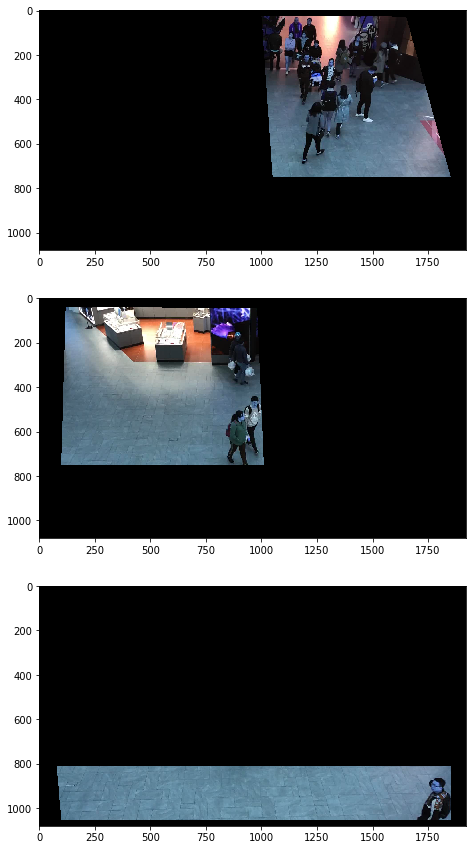

In [16]:
fig, axs = plt.subplots(3, figsize=(40, 15))
axs[0].imshow(zone_one_img)
axs[1].imshow(zone_two_img)
axs[2].imshow(zone_three_img)

The above picture shows how the images are going to be fed to the model. I've built a tool, that based on the points someone select can return a json, that later can be parsed by an inference pipeline and segment the images. The code can be found [here](https://github.com/gsam1/zone_of_interest_mapper). The code to parse the output will be up in *Utilities*.

In [17]:
zones = read_and_parse_zone_json('training_dataset/zones.json')

Now the zones object contains the correct order of points. Let's see what was created by the tool on the same image.

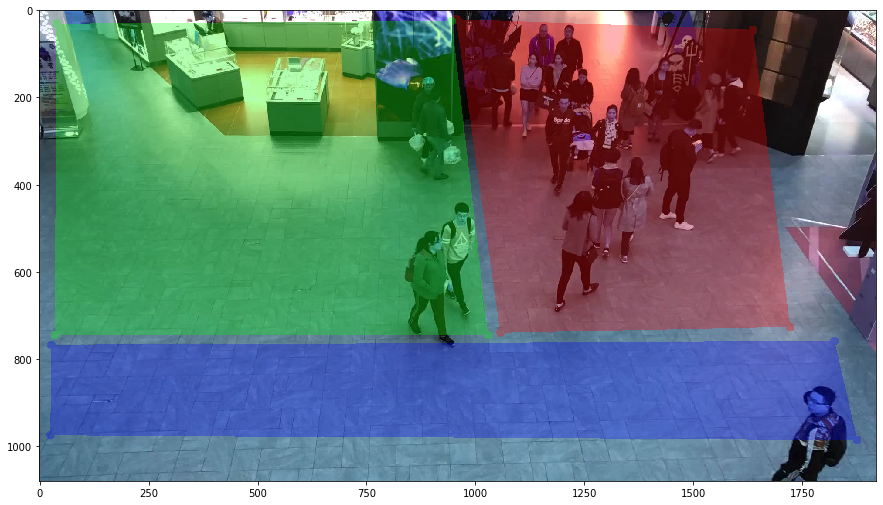

In [18]:
img = cv2.imread(EXAMPLE_IMAGE_JPG)

for point in zones['zone0']:
    cv2.circle(img, tuple(point), 10, (255, 0, 0), -1)

for point in zones['zone1']:
    cv2.circle(img, tuple(point), 10, (0, 255, 0), -1)

for point in zones['zone2']:
    cv2.circle(img, tuple(point), 10, (0, 0, 255), -1)

# add colors to the zones
active = 0
for zone in zones.keys():
    colors = [0, 0, 0]
    colors[active] = 255
    img = fill_zone(img, zones[zone], colors)
    active += 1

img = blend_images(cv2.imread(EXAMPLE_IMAGE_JPG), img, 0.3)
show_image(img)

Good enough :)

In [19]:
segmented_imgs = extract_images_from_zones(zones, cv2.imread(EXAMPLE_IMAGE_JPG))

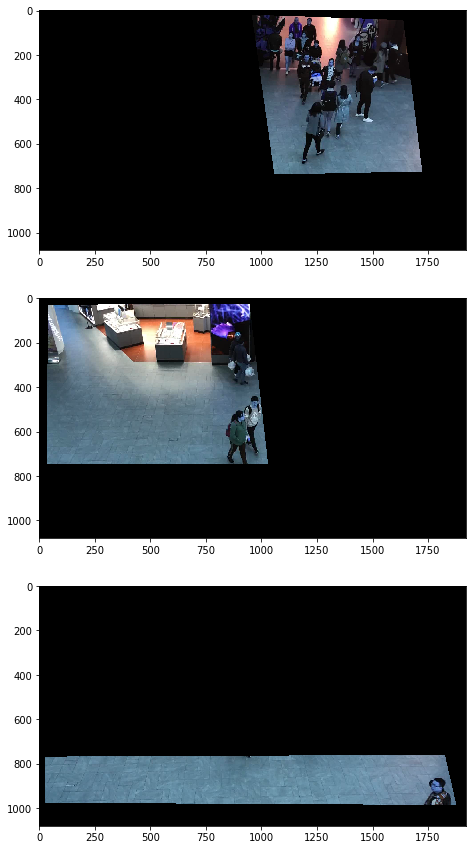

In [20]:
length_segments = len(segmented_imgs.keys())
fig, axs = plt.subplots(length_segments, figsize=(40, 15))
for i in range(0, length_segments):
    el = segmented_imgs[list(segmented_imgs.keys())[i]]
    axs[i].imshow(el)

### 3. Warp the perspective of a single image to 4 different images.

The idea is to create a test set, that will mimic the 4 different cameras in the layot. Instead of warping the perspective we can do an affine transformation. This way we can still preserve the parallel lines in the original image. Let's do it on the original image.

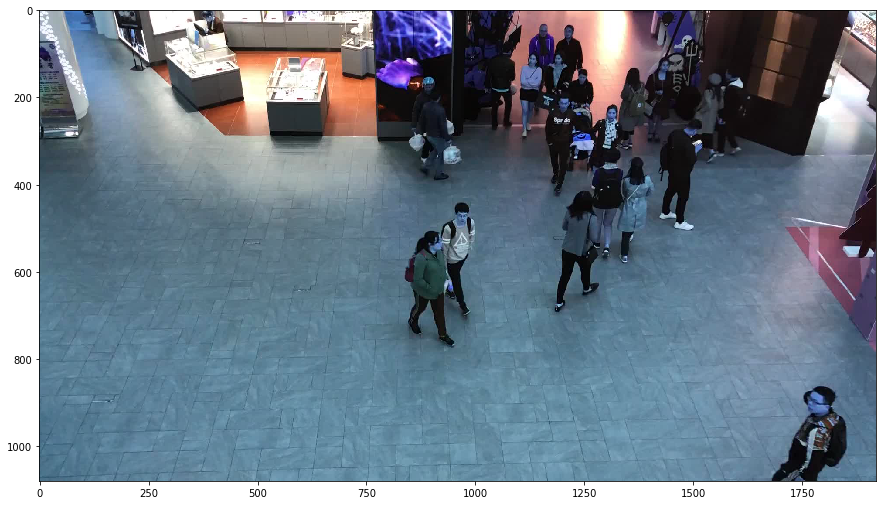

In [21]:
img = cv2.imread(EXAMPLE_IMAGE_JPG)
show_image(img)

#### 3.1 Test the defined functions for affline transformation

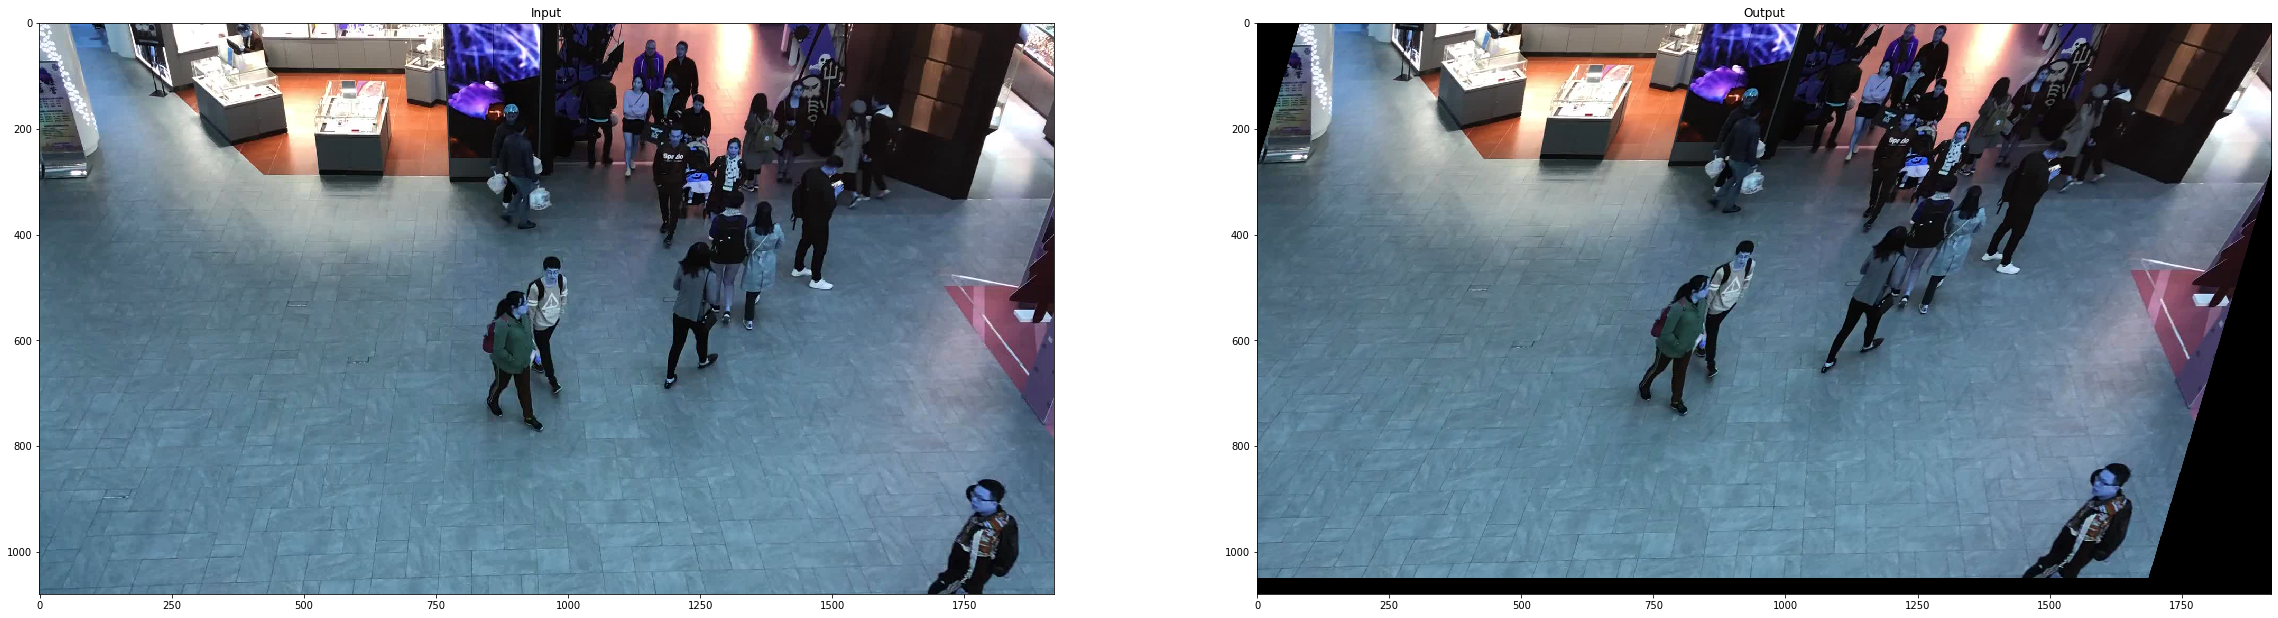

In [22]:
transformed_img = afflineTransform(img, [[500, 200], [1000, 200], [500, 400]], 30)
fig, axs = plt.subplots(2, figsize=(40, 15))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(transformed_img),plt.title('Output')
plt.show()

#### 3.2 Generate the output.

In [23]:
n_transforms = 3
anchor = [[500, 200], [1000, 200], [500, 400]]
drift = 30
result_imgs = apply_transforms(segmented_imgs, 3, anchor, drift)

In [24]:
# simple check to see if the numbers match
total = 0
for img in result_imgs:
    total += len(img.keys())

print(total)

12


### 4. Use the model to get the count of people in each segment of the image, as well as each perspective.
Now, with the help of pytorch we will begin inferencing. Since a single folder of the fdst dataset contains a camera in a fixed position, this is simmilar to the scenario we are building towards. Thus the goal is to run the pipeline through the whole folder.

*Note*: Some variable will be reinitialized to showcase the whole pipeline.

##### -- Image Preprocessing

In [25]:
def get_segments(zones, img_path):
    return extract_images_from_zones(zones, cv2.imread(img_path))

def get_img_name(path):
    return path.split('/')[-1].split('.')[0]

def preprocessed_image_generator(img_list, preprocess_config):
    '''
        Takes as an input the list tol loop through and 
        returns an array of all the available view angles
        per item on the img_list.
    '''
    zones = preprocess_config['zones']
    n_transforms = preprocess_config['n_transforms']
    anchor = preprocess_config['anchor']
    drift = preprocess_config['drift']
    
    for img_path in imgs_path_list:
        segmented_img = get_segments(zones, img_path)
        all_segments = apply_transforms(segmented_img, 
                                        n_transforms, 
                                        anchor, 
                                        drift,
                                       resize_to_target=True)
        # return the dict
        aug_img = {
            'name': get_img_name(img_path),
            'data': all_segments
        }
        # add a name parameter
        yield aug_img

##### -- Model Initialization and Inference Setup

In [30]:
def model_init(name):
    model = None
    if name == 'dsn':
        model = DenseScaleNet('')
    elif name == 'csr':
        model = CSRNet()
    else:
        raise exception('Wrong Model Specified')
    
    return model

def load_model_weight(weight_filepath, model):
    '''
        Loads the model from checkpoint_filepath.
    '''    
    state = torch.load(weight_filepath)
    model.load_state_dict(state['state_dict'])
    return model

def load_model(name, weight_path):
    model = model_init(name)
    model = load_model_weight(weight_path, model)
    
    return model

def infer_per_img_quad(img_quad, model, use_gpu=False):
    '''
        For a single image quad infer for each segment the results.
    '''
    # group by zones
    imgs_by_zone = {}
    for zone in zones.keys():
        imgs_by_zone[zone] = [img[zone] for img in img_quad]
    
    # infer per zone
    count_by_zone = {}
    # TODO: Add density maps as an output as well
    for zone in imgs_by_zone.keys():
        count_by_zone[zone] = []
        for img in imgs_by_zone[zone]:
            # reshape to fit the proper ratio
            img = np.reshape(img, (1, 3, MODEL_INPUT_SIZE[1], MODEL_INPUT_SIZE[0]))
            # convert to tensor
            img = torch.from_numpy(img).float()
            if use_gpu:
                img = img.cuda()
            density_map = model(img).detach()
            count_by_zone[zone].append(density_map.data.sum().numpy())
    
    return count_by_zone

##### -- Inference and Result Recording

In [27]:
def get_meta(img_name, model_name, count_by_zone):
    return {
            'name': img_name,
            'model': model_name,
            'count_by_zone': count_by_zone
    }

def inference(image_generator, inference_fun, model_name):
    # model init
    model = load_model(model_name, CSRNET_WEIGHTS_FILEPATH)
    
    result = []
    for img in image_generator:
        count_by_zone = inference_fun(img['data'], model)
        meta = get_meta(img['name'], model_name, count_by_zone)
        result.append(meta)
    
    return result

##### -- Execution

In [28]:
# Setup
# -- Load Imgs from fdst folder
imgs_path_list = glob.glob(os.path.join(FDST_TEST_IMAGES, '*.jpg'))
# -- get the predefined zones
zones = read_and_parse_zone_json('training_dataset/zones.json')
# Pre-processing
# -- define parameters in the parameter config object
preprocess_config = {
    'zones': zones,
    'n_transforms': 3,
    'anchor': [[500, 200], [1000, 200], [500, 400]],
    'drift': 30
    
}
# -- get preprocessing generator
image_generator = preprocessed_image_generator(imgs_path_list, preprocess_config)
# -- run inference
result = inference(image_generator, infer_per_img_quad, 'csr')

In [29]:
result

[{'name': '019',
  'model': 'csr',
  'count_by_zone': {'zone0': [tensor(6.7431),
    tensor(6.2951),
    tensor(5.8246),
    tensor(4.5319)],
   'zone1': [tensor(4.4349), tensor(4.5351), tensor(7.2898), tensor(4.7542)],
   'zone2': [tensor(4.7229), tensor(3.5467), tensor(4.7759), tensor(3.7750)]}},
 {'name': '109',
  'model': 'csr',
  'count_by_zone': {'zone0': [tensor(6.1602),
    tensor(4.1566),
    tensor(4.4376),
    tensor(4.7523)],
   'zone1': [tensor(7.0152), tensor(4.6374), tensor(4.9281), tensor(5.0463)],
   'zone2': [tensor(5.0796), tensor(4.2450), tensor(3.8647), tensor(4.3293)]}},
 {'name': '036',
  'model': 'csr',
  'count_by_zone': {'zone0': [tensor(4.7763),
    tensor(7.1376),
    tensor(7.1960),
    tensor(4.5846)],
   'zone1': [tensor(5.3326), tensor(4.5202), tensor(7.1806), tensor(4.5075)],
   'zone2': [tensor(4.7928), tensor(4.4760), tensor(4.5623), tensor(4.5266)]}},
 {'name': '063',
  'model': 'csr',
  'count_by_zone': {'zone0': [tensor(5.0131),
    tensor(6.5195),